In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Activation, Lambda
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
class modulator:
    def __init__(self, M, gray_map=True):
        N = np.log2(M)  # bits per symbol
        self.M = M  # modulation order
        self.N = int(N)  # bits per symbol
        self.m = [i for i in range(self.M)]
        self.gray_map = gray_map

    def __gray_encoding(self, dec_in):
        bin_seq = [np.binary_repr(d, width=self.N) for d in dec_in]
        gray_out = []
        for bin_i in bin_seq:
            gray_vals = [str(int(bin_i[idx]) ^ int(bin_i[idx - 1]))
                         if idx != 0 else bin_i[0]
                         for idx in range(0, len(bin_i))]
            gray_i = "".join(gray_vals)
            gray_out.append(int(gray_i, 2))
        return gray_out

    def create_constellation(self, m, s):
        if self.gray_map == False:
            mb = self.de2bin(m)
            dict_out = {k: v for k, v in zip(mb, s)}
        elif self.gray_map == True:
            mg = self.__gray_encoding(m)
            mgb = self.de2bin(mg)
            dict_out = {k: v for k, v in zip(mgb, s)}
        return dict_out

    def llr_preparation(self):
        code_book = self.code_book
        zeros = [[] for i in range(self.N)]
        ones = [[] for i in range(self.N)]
        bin_seq = self.de2bin(self.m)
        for bin_idx, bin_symb in enumerate(bin_seq):
            key = bin_symb
            for possition, digit in enumerate(bin_symb):
                if digit == '0':
                    zeros[possition].append(code_book[key])
                else:
                    ones[possition].append(code_book[key])
        return zeros, ones

    def modulate(self, msg):
        msg = [str(bit) for bit in msg]
        splited = ["".join(msg[i:i + self.N])  for i in range(0, len(msg), self.N)]  # subsequences of bits
        modulated = [self.code_book[s] for s in splited]
        return np.array(modulated)

class QAM(modulator):
    def __init__(self, M, gray_map=True):
        super().__init__(M, gray_map)
        if np.sqrt(M) != np.fix(np.sqrt(M)) or np.log2(np.sqrt(M)) != np.fix(np.log2(np.sqrt(M))):
            raise ValueError('M must be a square of a power of 2')
        self.m = [i for i in range(self.M)]
        self.s = self.__qam_symbols()
        self.code_book = self.create_constellation(self.m, self.s)
        if self.gray_map:
            self.__gray_qam_arange()

        self.zeros, self.ones = self.llr_preparation()

    def __qam_symbols(self):
        c = np.sqrt(self.M)
        b = -2 * (np.array(self.m) % c) + c - 1
        a = 2 * np.floor(np.array(self.m) / c) - c + 1
        s = list((a + 1j * b))
        return s

    def __gray_qam_arange(self):
        for idx, (key, item) in enumerate(self.code_book.items()):
            if (np.floor(idx / np.sqrt(self.M)) % 2) != 0:
                self.code_book[key] = np.conj(item)

    def de2bin(self, decs):
        bin_out = [np.binary_repr(d, width=self.N) for d in decs]
        return bin_out

In [3]:
fad_para = 0.5            # Rayleigh fading parameter
SNR = 25                  # SNR (dB) value used for training
M = 4                     # modulation order for QPSK
k = int(np.log2(M))       # bits per symbol
N = 64                    # no. of subcarriers
data = []                 # Initiates a varioable for training/testing dataset
BitsPerDataSeq = N * k    # no. of subcarriers x bits per symbol

learning_rate = 0.001     # Learning rate for the Adam Optimizer
weight_papr =  0.001      # try different values between 0.001 to 0.5 observe the accuracy and loss performance

batchsize = 100           # Size of each iteration
no_of_epochs = 50         # No. of iterations

train_dataset_size = 5000
test_dataset_size = 200000

In [4]:
# generate training dataset
data = []
for i in range(0, BitsPerDataSeq) :
  training = np.random.randint(2, size=train_dataset_size)
  data.append(training)

# convert list to an array
train_dataset = np.array(data)
train_dataset = train_dataset.reshape(-1, BitsPerDataSeq)

In [5]:
# print shape of training dataset
print(train_dataset.shape)

(5000, 128)


In [6]:
print(train_dataset)

[[1 1 0 ... 1 1 0]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 1 1 0]
 ...
 [0 1 1 ... 0 1 0]
 [0 0 0 ... 1 1 0]
 [1 0 1 ... 1 1 0]]


In [7]:
# generate test dataset
data = []
for i in range(0, BitsPerDataSeq) :
  testing = np.random.randint(2, size=test_dataset_size)
  data.append(testing)

# convert list to an array
test_dataset = np.array(data)
test_dataset = test_dataset.reshape(-1, BitsPerDataSeq)


#print test data and shape
print(test_dataset)
print(test_dataset.shape)


[[1 0 1 ... 0 1 0]
 [1 0 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 1 1]
 [1 1 0 ... 0 1 0]
 [0 1 0 ... 1 1 0]]
(200000, 128)


In [8]:
def IFFT(tensor):
    return tf.signal.ifft(tf.complex(tensor[:, 0:N], tensor[:, N:]))

In [9]:
# taking BitsPerDataSeq as input
inputs = Input(shape = (BitsPerDataSeq,))

# ------ Constellation Mapper Model --------
# Dense layer 1, Input shape = (None, 128), Output Shape = (None, 2048)
M_hidden_layer_1= Dense(2048, activation='relu')(inputs)
# BatchNormalization layer 1, Input shape = (None, 2048), Output Shape = (None, 2048)
M_hidden_layer_2 = BatchNormalization(center=False, scale=False)(M_hidden_layer_1)
# Activation layer 1, Input shape = (None, 2048), Output Shape = (None, 2048)
M_hidden_layer_3 = Activation('relu')(M_hidden_layer_2)

# Dense layer 2, Input shape = (None, 2048), Output Shape = (None, 1024)
M_hidden_layer_4 = Dense(1024, activation='relu')(M_hidden_layer_3)
# BatchNormalization layer 2, Input shape = (None, 1024), Output Shape = (None, 1024)
M_hidden_layer_5 = BatchNormalization(center=False, scale=False)(M_hidden_layer_4)
# Activation layer 2, Input shape = (None, 1024), Output Shape = (None, 1024)
M_hidden_layer_6 = Activation('relu')(M_hidden_layer_5)

# Dense layer 3, Input shape = (None, 1024), Output Shape = (None, 512)
M_hidden_layer_7 = Dense(512, activation='relu')(M_hidden_layer_6)
# BatchNormalization layer 3, Input shape = (None, 512), Output Shape = (None, 512)
M_hidden_layer_8 = BatchNormalization(center=False, scale=False)(M_hidden_layer_7)
# Activation layer 3, Input shape = (None, 512), Output Shape = (None, 512)
M_hidden_layer_9 = Activation('relu')(M_hidden_layer_8)

# Dense layer 4, Input shape = (None, 512), Output Shape = (None, 256)
M_hidden_layer_10 = Dense(256, activation='relu')(M_hidden_layer_9)
# BatchNormalization layer 4, Input shape = (None, 256), Output Shape = (None, 256)
M_hidden_layer_11 = BatchNormalization(center=False, scale=False)(M_hidden_layer_10)
# Activation layer 4, Input shape = (None, 256), Output Shape = (None, 256)
M_hidden_layer_12 = Activation('relu')(M_hidden_layer_11)

# Dense layer 5, Input shape = (None, 256), Output Shape = (None, 128)
e13 = Dense(BitsPerDataSeq, activation='sigmoid') (M_hidden_layer_12)

# IFFT layer, Input shape = (None, 128), Output Shape = (None, 64)
encoded_OFDM_symbol = Lambda(lambda x: IFFT(x), name='encoded_OFDM_symbol') (e13)

constellation_mapper = Model(inputs=inputs, outputs=encoded_OFDM_symbol)
print(constellation_mapper.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 2048)              264192    
                                                                 
 batch_normalization (Batch  (None, 2048)              4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              2048      
 chNormalization)                                            

In [10]:
# create channel model, apply equalizatopm and FFT ---

def Channel_Equalizer_FFT(tensor):
    # Compute symbol average
    symbol_avg = tf.reduce_mean(tf.square(tf.abs(tensor)))
    # Compute noise average using SNR
    SNR_lin = 10 ** (SNR / 10)
    noise_avg = symbol_avg/SNR_lin
    # Compute real component of noise
    noise_real = tf.math.real(noise_avg)
    # Compute imaginary component of noise
    noise_imag = tf.math.imag(noise_avg)
    # Generate the fading gain
    rayleigh_real = tf.sqrt(0.5)*tf.random.normal(shape=())
    rayleigh_imag = tf.sqrt(0.5)*tf.random.normal(shape=())
    #combine the real and imaginary parts
    rayleigh = tf.complex(rayleigh_real, rayleigh_imag)

    #Corruption = Channel Effect + AWGN
    #combine the real and imaginary parts for noise
    noise = tf.complex(noise_real, noise_imag)
    # Generate corruption using noise components and fading gain
    corruption = rayleigh + noise
    #Equalizing done on received signal
    equalized_recv_sig = corruption + encoded_OFDM_symbol

    #perform fft on the equlized received signal
    corrupted_bit_seq_complex = tf.signal.fft(equalized_recv_sig)

    return tf.keras.layers.Concatenate(axis=-1) ( [ tf.math.real( corrupted_bit_seq_complex ), tf.math.imag( corrupted_bit_seq_complex ) ] )

# ------ Channel + Equalizer + FFT --------
# taking encoded_OFDM_symbol as input, produce corrupted_bit_seq as output
corrupted_bit_seq = Channel_Equalizer_FFT(encoded_OFDM_symbol)
print(corrupted_bit_seq)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [11]:
# create Constellation Demapper Model ---
# ------ Constellation Demapper Model --------

# Dense layer 1, Input shape = (None, 128), Output Shape = (None, 2048)
D_hidden_layer_1= Dense(2048, activation='relu')(corrupted_bit_seq)
# BatchNormalization layer 1, Input shape = (None, 2048), Output Shape = (None, 2048)
D_hidden_layer_2 = BatchNormalization(center=False, scale=False)(D_hidden_layer_1)
# Activation layer 1, Input shape = (None, 128), Output Shape = (None, 2048)
D_hidden_layer_3 = Activation('relu')(D_hidden_layer_2)

# Dense layer 2, Input shape = (None, 2048), Output Shape = (None, 1024)
D_hidden_layer_4 = Dense(1024, activation='relu')(D_hidden_layer_3)
# BatchNormalization layer 2, Input shape = (None, 1024), Output Shape = (None, 1024)
D_hidden_layer_5 = BatchNormalization(center=False, scale=False)(D_hidden_layer_4)
# Activation layer 2, Input shape = (None, 1024), Output Shape = (None, 1024)
D_hidden_layer_6 = Activation('relu')(D_hidden_layer_5)

# Dense layer 3, Input shape = (None, 1024), Output Shape = (None, 512)
D_hidden_layer_7 = Dense(512, activation='relu')(D_hidden_layer_6)
# BatchNormalization layer 3, Input shape = (None, 512), Output Shape = (None, 512)
D_hidden_layer_8 = BatchNormalization(center=False, scale=False)(D_hidden_layer_7)
# Activation layer 3, Input shape = (None, 512), Output Shape = (None, 512)
D_hidden_layer_9 = Activation('relu')(D_hidden_layer_8)

# Dense layer 4, Input shape = (None, 512), Output Shape = (None, 256)
D_hidden_layer_10 = Dense(256, activation='relu')(D_hidden_layer_9)
# BatchNormalization layer 4, Input shape = (None, 256), Output Shape = (None, 256)
D_hidden_layer_11 = BatchNormalization(center=False, scale=False)(D_hidden_layer_10)
# Activation layer 4, Input shape = (None, 256), Output Shape = (None, 256)
D_hidden_layer_12 = Activation('relu')(D_hidden_layer_11)

# Dense layer 5, Input shape = (None, 256), Output Shape = (None, 128)
predicted_bit_seq = Dense(BitsPerDataSeq, activation='sigmoid', name='predicted_bit_seq') (D_hidden_layer_12)

# taking corrupted_bit_seq as input
# produce encoded_OFDM_symbol as predicted_bit_seq
constellation_demapper = Model(inputs=corrupted_bit_seq, outputs=predicted_bit_seq)

# define and print constellation demapper model summary
print(constellation_demapper.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_5 (Dense)             (None, 2048)              264192    
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              4096      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_5 (Bat  (None, 1024)              2048      
 chNormalization)                                          

In [12]:

def symbol_papr(y_true, y_pred):
    x = tf.square(tf.abs(y_pred))
    return 10*tf.experimental.numpy.log10(tf.reduce_mean(tf.reduce_max(x, axis=1) / tf.reduce_mean(x, axis=1)))


In [13]:
# create an autocoder model ---

# define and print autoencoder model summary
autoencoder = Model(inputs=inputs, outputs=[encoded_OFDM_symbol, predicted_bit_seq])

adam = Adam(learning_rate = 0.001)

autoencoder.compile(optimizer = adam,
                    loss = {'encoded_OFDM_symbol': symbol_papr, 'predicted_bit_seq': 'binary_crossentropy'},
                    loss_weights = [weight_papr, 1-weight_papr],
                    metrics = {'predicted_bit_seq':'binary_accuracy'})

print(autoencoder.summary())
# compile autoencoder model


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 2048)                 264192    ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048)                 4096      ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2048)                 0         ['batch_normalization[0]

In [14]:
# perform training on the autoencoder model
callback = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = autoencoder.fit(train_dataset, train_dataset, epochs= no_of_epochs, batch_size= batchsize, shuffle=True, callbacks=[callback], validation_split = 0.3)

# Evaluate the accuracy of decoding the transmitted bit sequence
results = autoencoder.evaluate(train_dataset, train_dataset, batch_size=batchsize)
print('test_loss, test_acc:', results)



Epoch 1/50
35/35 [==============================] - 11s 196ms/step - loss: 0.7583 - encoded_OFDM_symbol_loss: 17.3881 - predicted_bit_seq_loss: 0.7417 - predicted_bit_seq_binary_accuracy: 0.5223 - val_loss: 2.0974 - val_encoded_OFDM_symbol_loss: 18.0608 - val_predicted_bit_seq_loss: 2.0815 - val_predicted_bit_seq_binary_accuracy: 0.4994
Epoch 2/50
35/35 [==============================] - 7s 199ms/step - loss: 0.6960 - encoded_OFDM_symbol_loss: 17.3534 - predicted_bit_seq_loss: 0.6793 - predicted_bit_seq_binary_accuracy: 0.5703 - val_loss: 1.7694 - val_encoded_OFDM_symbol_loss: 18.0617 - val_predicted_bit_seq_loss: 1.7530 - val_predicted_bit_seq_binary_accuracy: 0.4997
Epoch 3/50
35/35 [==============================] - 6s 178ms/step - loss: 0.6645 - encoded_OFDM_symbol_loss: 17.3157 - predicted_bit_seq_loss: 0.6478 - predicted_bit_seq_binary_accuracy: 0.6136 - val_loss: 1.1132 - val_encoded_OFDM_symbol_loss: 18.0617 - val_predicted_bit_seq_loss: 1.0962 - val_predicted_bit_seq_binary_ac

In [15]:
def PAPR_of_Encoded_OFDM(encoded_data, dataset_size):
    PAPR_values = []  # Initialize a list to store PAPR values

    for symbol in encoded_symbols:
        peak_power = np.max(np.abs(symbol) ** 2)
        av_power = np.mean(np.abs(symbol) ** 2)
        PAPR = peak_power / av_power
        db_PAPR = 10 * np.log10(PAPR) #turn into decibels
        PAPR_values.append(db_PAPR) #turn it into a list
    PAPR_db = np.array(PAPR_values)
    return PAPR_db

def Modulation(data_non_modulated, N, size):
    data_modulated = np.zeros((size,N),dtype=complex)
    mod = QAM(M, gray_map=True)

    for i in range(size):
        data_modulated[i,:] = mod.modulate(data_non_modulated[i,:])
    return data_modulated

def PAPR_of_Classical_OFDM(modulated_data, dataset_size):
    PAPR_values = [] # Initialize a list to store PAPR values

    for symbol in modulated_data:
      ifft_symbol = tf.signal.ifft(symbol)
      peak_power = np.max(np.abs(ifft_symbol) ** 2)
      av_power = np.mean(np.abs(ifft_symbol) ** 2)
      PAPR = peak_power / av_power
      db_PAPR = 10 * np.log10(PAPR) #turn into decibels
      PAPR_values.append(db_PAPR) #turn it into a list
    PAPR_db = np.array(PAPR_values)
    return PAPR_db

In [16]:
# give the test_dataset to the trained autoencoder model to produce predictions
encoded_symbols, blabla = autoencoder.predict(test_dataset, batch_size = batchsize)
print(encoded_symbols)
print("Shape of Autoencoder Output Encoded Symbols:", encoded_symbols.shape)

Autoencoder_PAPR = PAPR_of_Encoded_OFDM(encoded_symbols, test_dataset_size)
# Print Autoencoder PAPR values
print(Autoencoder_PAPR)
print("Shape of the Autoencoder PAPR Values:", Autoencoder_PAPR.shape)

av_papr = np.mean(Autoencoder_PAPR)
av_papr_dB = 10 * np.log10(av_papr)
print("Autoencoder average PAPR Value:", av_papr_dB)

2000/2000 [==============================] - 70s 35ms/step
[[ 0.4503098 +0.45743853j  0.06577077+0.04799162j -0.0299861 +0.02039906j
  ... -0.03283386-0.06812052j -0.02351253+0.02226646j
   0.01116319-0.02340224j]
 [ 0.48390928+0.47152823j -0.01225367-0.00942424j -0.01763678+0.00679478j
  ... -0.02564916-0.05349276j -0.06055491+0.02005935j
   0.00441531+0.00432184j]
 [ 0.49214318+0.44203326j  0.00232829-0.04217337j -0.02545857+0.0266894j
  ...  0.00596637-0.05621819j -0.04111374+0.06701903j
  -0.01346496+0.05450277j]
 ...
 [ 0.43698677+0.4630744j   0.00696266+0.00912352j -0.02188423-0.02427686j
  ... -0.01779006-0.05246337j  0.01373956+0.01895735j
   0.01754291+0.02304513j]
 [ 0.46351454+0.4873395j  -0.05730154-0.02327275j -0.00549099+0.03868929j
  ... -0.03794684-0.05395224j  0.01217681+0.0367532j
  -0.04013445-0.0168378j ]
 [ 0.46873325+0.4923475j  -0.01349556-0.03718273j  0.00062801-0.04922437j
  ... -0.03082648-0.04207912j  0.029346  +0.08320145j
  -0.01131822+0.0242962j ]]
Shape o

In [17]:
Modulated_Data = Modulation(test_dataset, N, test_dataset_size)
print(Modulated_Data)
print(Modulated_Data.shape)

OFDM_PAPR = PAPR_of_Classical_OFDM(Modulated_Data, test_dataset_size)
print(OFDM_PAPR)
print(OFDM_PAPR.shape)


[[ 1.+1.j  1.+1.j  1.-1.j ...  1.-1.j  1.+1.j  1.+1.j]
 [ 1.+1.j  1.-1.j -1.+1.j ...  1.-1.j -1.+1.j  1.-1.j]
 [-1.+1.j -1.-1.j -1.+1.j ... -1.+1.j -1.+1.j -1.+1.j]
 ...
 [-1.-1.j -1.-1.j -1.+1.j ...  1.+1.j -1.+1.j  1.-1.j]
 [ 1.-1.j -1.-1.j -1.+1.j ...  1.-1.j  1.+1.j  1.+1.j]
 [-1.-1.j -1.+1.j  1.+1.j ...  1.-1.j  1.-1.j  1.+1.j]]
(200000, 64)
[6.59202874 5.94936252 7.22736776 ... 7.24317074 7.51497328 5.41219354]
(200000,)


In [18]:
av_papr_class = np.mean(OFDM_PAPR)
av_papr_class_dB = 10 * np.log10(av_papr_class)
print("Classical average PAPR Value:", av_papr_class_dB)

Classical average PAPR Value: 8.259838157203772


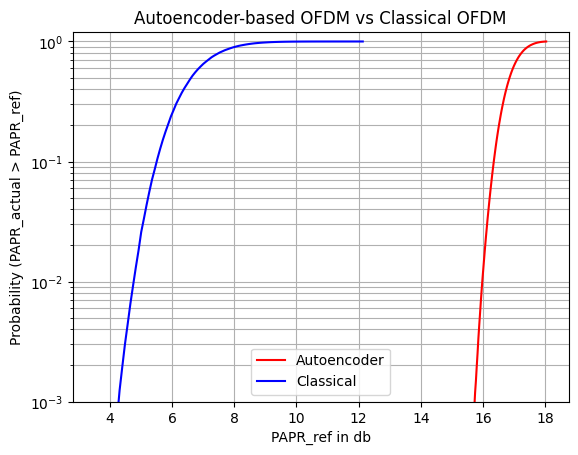

In [19]:
# note : plotting still in progress
plt.figure(1)
plt.xlabel('PAPR_ref in db')
plt.ylabel('Probability (PAPR_actual > PAPR_ref)')
plt.title("Autoencoder-based OFDM vs Classical OFDM")
plt.yscale('log')
plt.ylim(0.001, 1.2)
plt.grid(True, which="both")

# compute and plot bin edges on the x-axis and probability on y-axis for both schemes
hist_auto, bins_auto = np.histogram(Autoencoder_PAPR, bins=100)
hist_class, bins_class = np.histogram(OFDM_PAPR, bins=100)

# Calculate the CDF for PAPR values
autoencoder_papr_cdf = tf.math.cumsum(hist_auto[::-1])[::-1] / len(Autoencoder_PAPR)
classical_ofdm_papr_cdf = tf.math.cumsum(hist_class[::-1])[::-1] / len(OFDM_PAPR)

# Calculate the probability that PAPR > threshold for both schemes
autoencoder_papr_prob =  1 - autoencoder_papr_cdf
classical_ofdm_papr_prob = 1 - classical_ofdm_papr_cdf

plt.plot(bins_auto[:-1], autoencoder_papr_prob, 'r', label = 'Autoencoder')
plt.plot(bins_class[:-1], classical_ofdm_papr_prob, 'b', label = 'Classical')

plt.legend(['Autoencoder','Classical'])
plt.show()